In [1]:
# ==============================================================================
# SEL 1: Inisialisasi Library dan Penyiapan Seed
# ==============================================================================

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import random
import os

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# Menetapkan seed untuk reproduktifitas hasil
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
# Untuk memastikan hasil tetap sama saat dijalankan ulang
tf.config.experimental.enable_op_determinism()


In [2]:
# ==============================================================================
# SEL 2: Memuat Data Saham
# ==============================================================================

# Nama file CSV data saham
stock_file_name = "KLBF.csv"
# Membaca CSV
df = pd.read_csv("KLBF.csv")  # Menyesuaikan delimiter

# menghapus kolom yang semua isinya NaN
df = df.dropna(axis='columns', how='all')
# Menampilkan hasil
print(df)  # Cek apakah kolom sudah benar

# Konversi kolom 'Date' menjadi format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)


            Date  Close
0       2/1/2020   1615
1       3/1/2020   1635
2       6/1/2020   1640
3       7/1/2020   1635
4       8/1/2020   1585
...          ...    ...
1167  25/10/2024   1620
1168  28/10/2024   1630
1169  29/10/2024   1615
1170  30/10/2024   1605
1171  31/10/2024   1615

[1172 rows x 2 columns]


In [3]:
# ==============================================================================
# SEL 3: Memeriksa Nilai Null
# ==============================================================================

# Memeriksa data untuk nilai null
print("\nCek Nilai Null:")
print(df.isnull().sum())

if df.isnull().sum().any():
    print("\nWarning: Terdapat nilai null.")
else:
    print("\nTidak ada nilai null ditemukan.")


Cek Nilai Null:
Close    0
dtype: int64

Tidak ada nilai null ditemukan.


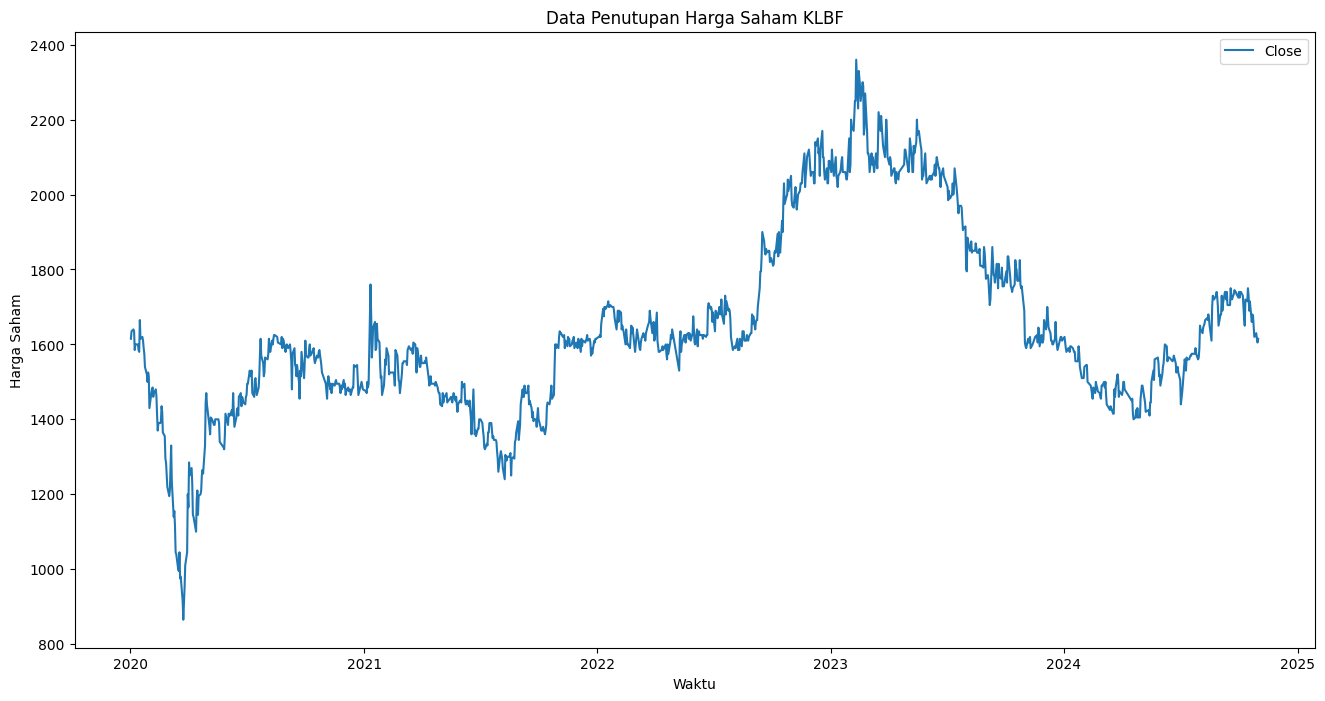


Grafik historis harga saham KLBF telah ditampilkan.


In [4]:
# ==============================================================================
# SEL 4: Visualisasi Data Historis
# ==============================================================================

# Ekstrak nama saham dari nama file untuk judul grafik
stock_name = stock_file_name.replace(".csv", "").upper()
# Visualisasi data historis
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close')
plt.title(f'Data Penutupan Harga Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

print(f"\nGrafik historis harga saham {stock_name} telah ditampilkan.")

In [5]:
# ==============================================================================
# SEL 5: Normalisasi Data
# ==============================================================================

# Menormalisasi data dengan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)
print("\nData Normalisasi:")
print(data_scaled)
print(f"Nilai terendah data asli (Xmin): {scaler.data_min_[0]:.2f}")
print(f"Nilai tertinggi data asli (Xmax): {scaler.data_max_[0]:.2f}")


Data Normalisasi:
[[0.50167224]
 [0.51505017]
 [0.51839465]
 ...
 [0.50167224]
 [0.49498328]
 [0.50167224]]
Nilai terendah data asli (Xmin): 865.00
Nilai tertinggi data asli (Xmax): 2360.00


In [6]:
# ==============================================================================
# SEL 6: Pembagian Data Latih dan Uji
# ==============================================================================

# Membagi data menjadi latih dan uji
training_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:training_size], data_scaled[training_size:]
print("Ukuran data training: ", train_data.shape)
print("Ukuran data testing : ", test_data.shape)

Ukuran data training:  (937, 1)
Ukuran data testing :  (235, 1)


In [7]:
# ==============================================================================
# SEL 7: Pembuatan Dataset Time-Series
# ==============================================================================

# Fungsi untuk membuat dataset time-series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:(i + time_step), 0]) # Ambil time_step data sebagai input
        dataY.append(dataset[i + time_step, 0]) # Data berikutnya sebagai prediksi
    return np.array(dataX), np.array(dataY)

# Definisikan time step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (877, 60)
Shape X_test: (175, 60)
Shape y_train: (877,)
Shape y_test: (175,)


In [8]:
# ==============================================================================
# SEL 8: Reshape Input untuk LSTM
# ==============================================================================

# Mengubah bentuk input untuk LSTM: (sampel, time_step, fitur)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (877, 60, 1)
Shape X_test: (175, 60, 1)


In [9]:
# ==============================================================================
# SEL 9: Membangun dan Melatih Model LSTM
# ==============================================================================

# Membuat Model LSTM
n_neurons = 50
epochs = 200
batch_size = 16

model = Sequential([
    LSTM(n_neurons, activation='tanh', recurrent_activation="sigmoid", input_shape=(time_step, 1)),
    Dense(1) # Menggunakan sigmoid untuk output layer
])

# Mengkompilasi model (Optimizer Adam, Loss MSE)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
print(f"\nMemulai pelatihan model LSTM (Epochs={epochs}, Batch Size={batch_size})...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)
print("\nPelatihan selesai.")


Memulai pelatihan model LSTM (Epochs=200, Batch Size=16)...
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.1173 - val_loss: 0.0013
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0023 - val_loss: 8.4547e-04
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 7.4991e-04
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 7.4367e-04
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 7.3232e-04
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 7.1470e-04
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 6.9710e-04
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 6.8173e-04
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0013 - val_loss: 6.6835e-04
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0013 - val_loss: 6.5672e-04
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 6.4671e-04
Epoch 12/200
55/55 ━━━━

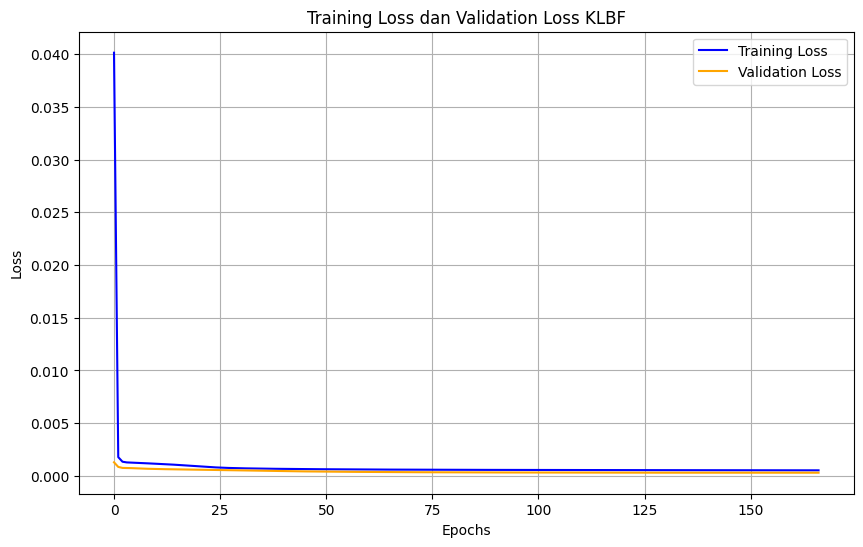


Grafik Training Loss dan Validation Loss telah ditampilkan.


In [10]:
# ==============================================================================
# SEL 10: Visualisasi Training Loss dan Validation Loss
# ==============================================================================

# Visualisasi Training Loss dan Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Training Loss dan Validation Loss {stock_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nGrafik Training Loss dan Validation Loss telah ditampilkan.")

In [11]:
# ==============================================================================
# SEL 11: Ekstraksi Bobot dan Bias Awal LSTM
# Untuk menyimpan bobot awal model yang dilatih Keras
# ==============================================================================

#  Ambil Bobot Awal dari layer LSTM dan Dense
lstm_weights = model.layers[0].get_weights()
W, U, b = lstm_weights[0], lstm_weights[1], lstm_weights[2]

dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]

# Pecah Bobot LSTM ke Setiap Gate (sesuai urutan di skripsi: f, i, c, o)

def split_weights(W, U, b):
    W_i, W_f, W_c, W_o = np.split(W, 4, axis=1)  # kernel weights
    U_i, U_f, U_c, U_o = np.split(U, 4, axis=1)  # recurrent weights
    b_i, b_f, b_c, b_o = np.split(b, 4)  # biases
    return (W_i, U_i, b_i), (W_f, U_f, b_f), (W_c, U_c, b_c), (W_o, U_o, b_o)

(Wi, Ui, bi), (Wf, Uf, bf), (Wc, Uc, bc), (Wo, Uo, bo) = split_weights(W, U, b)

# Keras menyimpan dalam urutan (i, f, c, o)
target_file = "LSTM_Weights.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(Wi).to_excel(writer, sheet_name="Wi")
    pd.DataFrame(Ui).to_excel(writer, sheet_name="Ui")
    pd.DataFrame(bi).to_excel(writer, sheet_name="bi")

    pd.DataFrame(Wf).to_excel(writer, sheet_name="Wf")
    pd.DataFrame(Uf).to_excel(writer, sheet_name="Uf")
    pd.DataFrame(bf).to_excel(writer, sheet_name="bf")

    pd.DataFrame(Wc).to_excel(writer, sheet_name="Wc")
    pd.DataFrame(Uc).to_excel(writer, sheet_name="Uc")
    pd.DataFrame(bc).to_excel(writer, sheet_name="bc")

    pd.DataFrame(Wo).to_excel(writer, sheet_name="Wo")
    pd.DataFrame(Uo).to_excel(writer, sheet_name="Uo")
    pd.DataFrame(bo).to_excel(writer, sheet_name="bo")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Weights.xlsx telah disimpan! ==


In [12]:
# ==============================================================================
# SEL 12: Simulasi Perhitungan Manual Forward Pass Pada Batch Pertama
# ==============================================================================

# Fungsi Sigmoid dan Tanh untuk Perhitungan Manual
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Hitung Forward Pass

def lstm_forward(X, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc):
    batch_size, time_steps, input_dim = X.shape
    hidden_dim = Ui.shape[0]  # Jumlah unit LSTM

    h_t = np.zeros((batch_size, hidden_dim))  # Hidden state awal
    c_t = np.zeros((batch_size, hidden_dim))  # Cell state awal

    for t in range(time_steps):
        x_t = X[:, t, :]  # Ambil input per time step

        # Hitung setiap gate
        i_t = sigmoid(np.dot(x_t, Wi) + np.dot(h_t, Ui) + bi)  # Input gate
        f_t = sigmoid(np.dot(x_t, Wf) + np.dot(h_t, Uf) + bf)  # Forget gate
        o_t = sigmoid(np.dot(x_t, Wo) + np.dot(h_t, Uo) + bo)  # Output gate
        c_tilde = tanh(np.dot(x_t, Wc) + np.dot(h_t, Uc) + bc)  # Candidate cell state

        # Update cell state dan hidden state
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * tanh(c_t)

    return i_t, f_t, o_t, c_tilde, h_t, c_t

# Ambil batch pertama
batch_sample = X_train[:16]

# Hitung forward pass
i_t, f_t, o_t, c_tilde, h_t, c_t = lstm_forward(
    batch_sample, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc
)

# Hitung Output dari Dense Layer
dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]
dense_output = np.dot(h_t, Wd) + bd

# Simpan Hasil Forward Pass ke dalam Excel
target_file = "LSTM_Forward_Pass.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input_Gate")
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget_Gate")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output_Gate")
    pd.DataFrame(c_tilde).to_excel(writer, sheet_name="Cell_Candidate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden_State")
    pd.DataFrame(c_t).to_excel(writer, sheet_name="Cell_State")
    pd.DataFrame(dense_output).to_excel(writer, sheet_name="Dense_Output")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Forward_Pass.xlsx telah disimpan! ==


In [13]:
# ==============================================================================
# SEL 13: Simulasi Perhitungan Manual Gradien (Backpropagation)
# ==============================================================================

# Cek apakah model sudah dilatih
assert 'model' in globals(), "Model belum dilatih! Jalankan pelatihan terlebih dahulu."

# Definisikan fungsi loss
loss_fn = tf.keras.losses.MeanSquaredError()

# Gunakan GradientTape untuk menghitung gradien
def compute_gradients(model, X_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=True)
        loss = loss_fn(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# Ambil batch pertama untuk perhitungan gradien
X_batch, y_batch = X_train[:16], y_train[:16]
gradients = compute_gradients(model, X_batch, y_batch)

# 4. Pecah gradien ke setiap gate
W_grad, U_grad, b_grad = gradients[0].numpy(), gradients[1].numpy(), gradients[2].numpy()

def split_gradients(W, U, b):
    dWi, dWf, dWc, dWo = np.split(W, 4, axis=1)
    dUi, dUf, dUc, dUo = np.split(U, 4, axis=1)
    dbi, dbf, dbc, dbo = np.split(b, 4)
    return (dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo)

(dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo) = split_gradients(W_grad, U_grad, b_grad)

# 5. Simpan hasil gradien ke dalam file Excel
file_name = "LSTM_Gradients.xlsx"
with pd.ExcelWriter(file_name) as writer:
    pd.DataFrame(dWi).to_excel(writer, sheet_name="dWi")
    pd.DataFrame(dUi).to_excel(writer, sheet_name="dUi")
    pd.DataFrame(dbi).to_excel(writer, sheet_name="dbi")

    pd.DataFrame(dWf).to_excel(writer, sheet_name="dWf")
    pd.DataFrame(dUf).to_excel(writer, sheet_name="dUf")
    pd.DataFrame(dbf).to_excel(writer, sheet_name="dbf")

    pd.DataFrame(dWc).to_excel(writer, sheet_name="dWc")
    pd.DataFrame(dUc).to_excel(writer, sheet_name="dUc")
    pd.DataFrame(dbc).to_excel(writer, sheet_name="dbc")

    pd.DataFrame(dWo).to_excel(writer, sheet_name="dWo")
    pd.DataFrame(dUo).to_excel(writer, sheet_name="dUo")
    pd.DataFrame(dbo).to_excel(writer, sheet_name="dbo")

print(f"\n== File {file_name} telah disimpan! ==")



== File LSTM_Gradients.xlsx telah disimpan! ==


In [14]:
# ==============================================================================
# SEL 14: Simulasi Perhitungan Manual Update Bobot Adam
# ==============================================================================

# Adam Optimizer Parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Inisialisasi m dan v untuk Adam
m_W, v_W = np.zeros_like(W), np.zeros_like(W)
m_U, v_U = np.zeros_like(U), np.zeros_like(U)
m_b, v_b = np.zeros_like(b), np.zeros_like(b)

t = 1  # Iterasi pertama Adam

def adam_update(param, grad, m, v, t, lr=learning_rate, beta1=beta1, beta2=beta2, eps=epsilon):
    """Fungsi untuk memperbarui parameter menggunakan Adam optimizer"""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

# Update bobot dan bias untuk setiap gate
W_new, m_W, v_W = adam_update(W, W_grad, m_W, v_W, t)
U_new, m_U, v_U = adam_update(U, U_grad, m_U, v_U, t)
b_new, m_b, v_b = adam_update(b, b_grad, m_b, v_b, t)

# Pecah bobot baru ke dalam setiap gate
(Wi_new, Ui_new, bi_new), (Wf_new, Uf_new, bf_new), (Wc_new, Uc_new, bc_new), (Wo_new, Uo_new, bo_new) = split_weights(W_new, U_new, b_new)

# Simpan bobot baru ke dalam file Excel
updated_weights_file = "LSTM_Updated_Weights.xlsx"
with pd.ExcelWriter(updated_weights_file) as writer:
    pd.DataFrame(Wi_new).to_excel(writer, sheet_name="Wi_New")
    pd.DataFrame(Ui_new).to_excel(writer, sheet_name="Ui_New")
    pd.DataFrame(bi_new).to_excel(writer, sheet_name="bi_New")

    pd.DataFrame(Wf_new).to_excel(writer, sheet_name="Wf_New")
    pd.DataFrame(Uf_new).to_excel(writer, sheet_name="Uf_New")
    pd.DataFrame(bf_new).to_excel(writer, sheet_name="bf_New")

    pd.DataFrame(Wc_new).to_excel(writer, sheet_name="Wc_New")
    pd.DataFrame(Uc_new).to_excel(writer, sheet_name="Uc_New")
    pd.DataFrame(bc_new).to_excel(writer, sheet_name="bc_New")

    pd.DataFrame(Wo_new).to_excel(writer, sheet_name="Wo_New")
    pd.DataFrame(Uo_new).to_excel(writer, sheet_name="Uo_New")
    pd.DataFrame(bo_new).to_excel(writer, sheet_name="bo_New")

print(f"\n== Bobot dan bias baru telah disimpan di {updated_weights_file}! ==")



== Bobot dan bias baru telah disimpan di LSTM_Updated_Weights.xlsx! ==


In [15]:
# ==============================================================================
# SEL 15: Evaluasi Model dengan MAPE
# ==============================================================================

# 3. Evaluasi Model
# Membuat prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Mengembalikan data ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Menghitung metrik evaluasi untuk data latih dan uji
train_mape = np.mean(np.abs((y_train_original - train_predict) / y_train_original)) * 100
test_mape = np.mean(np.abs((y_test_original - test_predict) / y_test_original)) * 100

print("\nEvaluasi Model:")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Evaluasi Model:
Train MAPE: 1.4546046836130535%
Test MAPE: 1.2587957095697584%


In [16]:
# Mengambil bobot dari layer LSTM
lstm_layer = model.layers[0]  # Lapisan LSTM
weights = lstm_layer.get_weights()


# Memisahkan bobot menjadi Kernel (W), Recurrent weights (U), dan Bias (b)
W = weights[0]  # Kernel weights (input to gates)
U = weights[1]  # Recurrent weights (hidden state to gates)
b = weights[2]  # Bias

# Menampilkan ukuran setiap bobot
print("Shape of W (bobot input):", W.shape)
print("Shape of U (Bobot hidden state):", U.shape)
print("Shape of b (Bias):", b.shape)

# Memisahkan bobot untuk setiap gate
units = lstm_layer.units  # Jumlah unit (neurons) dalam LSTM

W_f, W_i, W_c, W_o = W[:, :units], W[:, units:2*units], W[:, 2*units:3*units], W[:, 3*units:]
U_f, U_i, U_c, U_o = U[:, :units], U[:, units:2*units], U[:, 2*units:3*units], U[:, 3*units:]
b_f, b_i, b_c, b_o = b[:units], b[units:2*units], b[2*units:3*units], b[3*units:]


Shape of W (bobot input): (1, 200)
Shape of U (Bobot hidden state): (50, 200)
Shape of b (Bias): (200,)


In [17]:
# Menampilkan bobot untuk Forget Gate
print("W_f (Bobot Input untuk Forget Gate):\n", W_f)
print("U_f (Bobot hidden state untuk Forget Gate):\n", U_f)
print("b_f (Bias untuk Forget Gate):\n", b_f)

print("Shape of W_f:", W_f.shape)
print("Shape of U_f:", U_f.shape)
print("Shape of b_f:", b_f.shape)

W_f (Bobot Input untuk Forget Gate):
 [[ 2.13290960e-01  1.38052478e-01 -6.73678741e-02  1.33248687e-01
  -3.83931398e-01  1.10944934e-01  1.18096165e-01 -8.62057731e-02
  -1.27776656e-02  8.62101614e-02 -1.99067127e-02  3.77693102e-02
   2.32675627e-01 -7.61658838e-03  1.81577858e-02  3.10334861e-01
  -1.90090045e-01 -1.33904651e-01  3.35575722e-04  1.39321446e+00
  -1.49159521e-01  1.86375260e-01  1.26495004e-01  4.22695652e-02
   2.19125539e-01 -5.67612946e-02  7.96117336e-02  1.24562263e-01
   1.36331469e-01 -4.35070358e-02 -6.03705905e-02  2.08634794e-01
  -5.45548350e-02  7.29032233e-02 -1.39212564e-01 -2.17793956e-01
   1.76117793e-01 -1.05269700e-01  1.25651464e-01  5.36904223e-02
  -1.79830387e-01  2.67802179e-01 -1.74912848e-02  5.33412322e-02
   3.15763801e-01  4.45300490e-02  4.67039123e-02 -2.05218896e-01
  -4.33772765e-02  2.00744778e-01]]
U_f (Bobot hidden state untuk Forget Gate):
 [[ 0.04089036 -0.03392494  0.04215194 ... -0.09897655 -0.10899742
  -0.00969514]
 [ 0.041

In [18]:
# Menampilkan bobot untuk Input Gate
print("W_i (Bobot Input untuk Input Gate):\n", W_i)
print("U_i (Bobot hidden state untuk Input Gate):\n", U_i)
print("b_i (Bias untuk Input Gate):\n", b_i)
print("Shape of W_i:", W_i.shape)
print("Shape of U_i:", U_i.shape)
print("Shape of b_i:", b_i.shape)

W_i (Bobot Input untuk Input Gate):
 [[ 0.07616359  0.05300014 -0.20313896 -0.11905549  0.01294098  0.14266726
  -0.02263963 -0.05738712 -0.1180627  -0.1485013   0.13307887  0.15181525
   0.02574502  0.09608424 -0.05236108  0.2343236  -0.07031501 -0.05115926
   0.12740164  0.26378158  0.07840174  0.17400292  0.14343297 -0.02646054
   0.19469467 -0.13430893  0.22822495  0.13664329  0.0870637  -0.11381685
  -0.07627761  0.19916464 -0.14556265 -0.0638499  -0.14928761 -0.17193459
   0.1910478   0.11889726  0.08716651  0.01099432 -0.00746031  0.2003596
   0.01204896 -0.08618625  0.26894325  0.01157723  0.13665025  0.04440394
   0.06006901 -0.11798102]]
U_i (Bobot hidden state untuk Input Gate):
 [[ 0.04032231  0.07641074 -0.16801186 ... -0.07006033  0.02423575
  -0.11480404]
 [-0.12309355  0.00910046  0.00354969 ... -0.23219462 -0.00382356
   0.12046508]
 [-0.10698423  0.07001584 -0.00689108 ... -0.05611276 -0.0767843
   0.07391544]
 ...
 [ 0.13340287  0.17818533 -0.06835526 ... -0.13959877

In [19]:
# Menampilkan bobot untuk Cell State
print("W_c (Bobot Input untuk Cell State):\n", W_c)
print("U_c (Bobot hidden state untuk Cell State):\n", U_c)
print("b_c (Bias untuk Cell State):\n", b_c)
print("Shape of W_c:", W_c.shape)
print("Shape of U_c:", U_c.shape)
print("Shape of b_c:", b_c.shape)

W_c (Bobot Input untuk Cell State):
 [[ 0.22007498  0.18976864  0.03483574 -0.0727664  -0.03536     0.1260937
  -0.04499942  0.07069511  0.0790634   0.07829117 -0.16620333  0.12542638
  -0.05770821  0.11792394  0.01309125 -0.13971438  0.10209202 -0.16371848
  -0.04786879 -0.61417645  0.03909637 -0.19628182 -0.07353574  0.22961982
   0.00437969 -0.13416892  0.19458951 -0.20444994  0.1193788  -0.13387242
   0.13674095 -0.10273466 -0.04910118 -0.09832238 -0.01413057 -0.06611162
  -0.0678119   0.00352993  0.2089485  -0.0799415  -0.10318004 -0.24957691
   0.06910515  0.18690161  0.16728066  0.0960019  -0.05809638  0.12292808
   0.03953794 -0.13895877]]
U_c (Bobot hidden state untuk Cell State):
 [[-0.18704467 -0.00184245  0.00142499 ... -0.03127458  0.07491257
   0.04176205]
 [-0.04068836 -0.01235879  0.12889157 ...  0.06293067 -0.07492872
   0.00776119]
 [ 0.02111437  0.06782473 -0.08885168 ...  0.03977582  0.04634527
   0.00232447]
 ...
 [ 0.14687492 -0.06476665  0.14789338 ...  0.0762051

In [20]:
# Menampilkan bobot untuk Output Gate
print("W_o (Bobot Input untuk Output Gate):\n", W_o)
print("U_o (Bobot hidden state untuk Output Gate):\n", U_o)
print("b_o (Bias untuk Output Gate):\n", b_o)
print("Shape of W_o:", W_o.shape)
print("Shape of U_o:", U_o.shape)
print("Shape of b_o:", b_o.shape)

W_o (Bobot Input untuk Output Gate):
 [[ 0.15064877  0.3170611  -0.15128276 -0.01282481 -0.2984115  -0.10336608
   0.10351019 -0.01025732  0.18741769  0.20428963  0.2663245   0.15720068
  -0.01887647  0.13283066  0.19390035  0.23362091  0.11842292 -0.08449746
   0.17567651  1.4259013  -0.02805407  0.13880649  0.0530281   0.22096322
   0.40809137  0.27665332  0.13879253  0.07534695  0.33257383 -0.08946383
   0.05079613  0.22275858 -0.02150657  0.12398463 -0.15118894 -0.17238446
   0.26419252 -0.02208469  0.02402916 -0.06598811 -0.00610664  0.36861145
   0.08815162  0.256981    0.39755985  0.3181314   0.12144397 -0.11192897
   0.4151412   0.27111363]]
U_o (Bobot hidden state untuk Output Gate):
 [[-0.00807766  0.08516278  0.11245931 ... -0.12202787 -0.1602202
   0.03774452]
 [ 0.07868275  0.00673569 -0.06104443 ... -0.07832365 -0.1274622
  -0.06056393]
 [-0.03822285  0.02501953  0.02453533 ... -0.04876531 -0.19523202
  -0.11797539]
 ...
 [ 0.10402123  0.01359111 -0.05588087 ... -0.237595

In [21]:
# Menyimpan semua bobot dan bias ke dalam satu file Excel
with pd.ExcelWriter("LSTM_Weights_Biases.xlsx", engine="openpyxl") as writer:
    pd.DataFrame(W_f).to_excel(writer, sheet_name="W_f (Forget Gate)", index=False)
    pd.DataFrame(W_i).to_excel(writer, sheet_name="W_i (Input Gate)", index=False)
    pd.DataFrame(W_c).to_excel(writer, sheet_name="W_c (Candidate Gate)", index=False)
    pd.DataFrame(W_o).to_excel(writer, sheet_name="W_o (Output Gate)", index=False)

    pd.DataFrame(U_f).to_excel(writer, sheet_name="U_f (Forget Gate)", index=False)
    pd.DataFrame(U_i).to_excel(writer, sheet_name="U_i (Input Gate)", index=False)
    pd.DataFrame(U_c).to_excel(writer, sheet_name="U_c (Candidate Gate)", index=False)
    pd.DataFrame(U_o).to_excel(writer, sheet_name="U_o (Output Gate)", index=False)

    pd.DataFrame(b_f).to_excel(writer, sheet_name="b_f (Forget Gate)", index=False)
    pd.DataFrame(b_i).to_excel(writer, sheet_name="b_i (Input Gate)", index=False)
    pd.DataFrame(b_c).to_excel(writer, sheet_name="b_c (Candidate Gate)", index=False)
    pd.DataFrame(b_o).to_excel(writer, sheet_name="b_o (Output Gate)", index=False)

print("Semua bobot dan bias berhasil disimpan dalam satu file Excel!")

Semua bobot dan bias berhasil disimpan dalam satu file Excel!


In [22]:
# === Ambil Bobot & Bias Dense Layer ===
dense_weights, dense_bias = model.layers[1].get_weights()

print("W_dense: ", dense_weights)
print("b_dense: ", dense_bias)

W_dense:  [[ 0.2884397 ]
 [ 0.14969581]
 [ 0.02972038]
 [ 0.07755661]
 [ 0.08496772]
 [ 0.22834684]
 [ 0.19051984]
 [ 0.26467958]
 [-0.1581375 ]
 [ 0.1311575 ]
 [-0.32916176]
 [ 0.1862476 ]
 [-0.10420301]
 [-0.0283689 ]
 [-0.00233422]
 [-0.3612853 ]
 [-0.12523721]
 [-0.06774821]
 [ 0.21187492]
 [-0.6277178 ]
 [ 0.0540617 ]
 [-0.11172207]
 [ 0.26991913]
 [ 0.2933555 ]
 [-0.24359752]
 [-0.12358811]
 [ 0.3423296 ]
 [-0.36048028]
 [ 0.37703535]
 [-0.08994391]
 [ 0.23456237]
 [-0.064846  ]
 [-0.24484321]
 [-0.2392046 ]
 [ 0.19327623]
 [ 0.21726404]
 [-0.2467865 ]
 [-0.07846296]
 [ 0.33818746]
 [-0.0333717 ]
 [-0.00348503]
 [-0.22858047]
 [ 0.14475049]
 [ 0.2558696 ]
 [ 0.10165174]
 [ 0.29732248]
 [-0.27520722]
 [-0.21935071]
 [ 0.17907193]
 [-0.23537198]]
b_dense:  [0.02453647]


In [23]:
# ==============================================================================
# Training Data
# ==============================================================================

# === Fungsi aktivasi ===
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# === Gunakan X_test asli ===
print("Shape X_test:", X_test.shape)  # Pastikan ukurannya (175, 90, 1)

# === Inisialisasi hidden state & cell state ===
h_t = np.zeros((175, 50))
C_t = np.zeros((175, 50))

# === Forward Pass X_test Asli ===
for t in range(60):  # Looping tiap timestep
    x_t = X_test[:, t, :]  # Ambil input di timestep t → (175, 1)

    # Forget gate
    f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f.T)  # (175, 50)

    # Input gate
    i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i.T)  # (175, 50)

    # Candidate cell state
    C_tilde_t = tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c.T)  # (175, 50)

    # Cell state update
    C_t = f_t * C_t + i_t * C_tilde_t  # (175, 50)

    # Output gate
    o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o.T)  # (175, 50)

    # Hidden state update
    h_t = o_t * tanh(C_t)  # (175, 50)

    # === Hitung Output Dense Layer ===
    y_pred = np.dot(h_t, dense_weights) + dense_bias  # (175, 1)



# === Print hasil akhir ===
print("Forget Gate (f_t):", f_t)
print("Input Gate (i_t):", i_t)
print("Candidate Cell State (C_tilde_t):", C_tilde_t)
print("Cell State (C_t):", C_t)
print("Output Gate (o_t):", o_t)
print("Hidden State (h_t):", h_t)
print("\nOutput Dense Layer (y_pred):", y_pred)

print("\nUkuran Forget Gate (f_t):", f_t.shape)
print("Ukuran Input Gate (i_t):", i_t.shape)
print("Ukuran Candidate Cell State (C_tilde_t):", C_tilde_t.shape)
print("Ukuran Cell State (C_t):", C_t.shape)
print("Ukuran Output Gate (o_t):", o_t.shape)
print("Ukuran Hidden State (h_t):", h_t.shape)  # (175, 50)
print("Ukuran Output Dense Layer (y_pred):", y_pred.shape)  # (175, 1)


Shape X_test: (175, 60, 1)
Forget Gate (f_t): [[0.56691301 0.52288678 0.48024073 ... 0.36718514 0.47685001 0.55745751]
 [0.56780707 0.52371708 0.47991338 ... 0.36706402 0.47693287 0.5585827 ]
 [0.5686741  0.52402047 0.47950399 ... 0.36547873 0.47677004 0.55961509]
 ...
 [0.5777144  0.5232997  0.47791553 ... 0.3384878  0.46913552 0.56110139]
 [0.57697036 0.52314458 0.47809399 ... 0.34002102 0.46957611 0.56071385]
 [0.57611204 0.52305274 0.47832692 ... 0.34213496 0.47012686 0.56027579]]
Input Gate (i_t): [[0.72964519 0.72029809 0.68241744 ... 0.66032317 0.73359377 0.70231149]
 [0.73004534 0.72067078 0.68171404 ... 0.66137724 0.73393835 0.70185819]
 [0.73003057 0.72052617 0.68107285 ... 0.66052116 0.73393201 0.70167903]
 ...
 [0.72844396 0.71699296 0.67265374 ... 0.63847744 0.73280221 0.69742463]
 [0.72844087 0.71709327 0.67329749 ... 0.63943399 0.73281598 0.69776808]
 [0.72854628 0.71734614 0.67407501 ... 0.64100696 0.73288855 0.69810036]]
Candidate Cell State (C_tilde_t): [[ 0.05514286 

In [24]:
# === Simpan hasil ke dalam Excel ===
file_path = "hasil_forward_pass.xlsx"
with pd.ExcelWriter(file_path) as writer:
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget Gate")
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input Gate")
    pd.DataFrame(C_tilde_t).to_excel(writer, sheet_name="Candidate Cell State")
    pd.DataFrame(C_t).to_excel(writer, sheet_name="Cell State")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output Gate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden State")
    pd.DataFrame(y_pred).to_excel(writer, sheet_name="Dense layer")

print(f"\n✅ Hasil forward pass telah disimpan di: {file_path}")


✅ Hasil forward pass telah disimpan di: hasil_forward_pass.xlsx


In [25]:
# ==============================================================================
# Akurasi Data Train, Test, dan Keseluruhan
# ==============================================================================

# Hitung rata-rata akurasi untuk data latih
train_accuracy_percentage = (1 - (train_mape / 100)) * 100
# Hitung rata-rata akurasi untuk data uji
test_accuracy_percentage = (1 - (test_mape / 100)) * 100
# Hitung rata-rata akurasi keseluruhan
overall_accuracy_percentage = ((train_accuracy_percentage + test_accuracy_percentage) / 2)

# Tampilkan metrik akurasi untuk data latih
print("Akurasi Data Latih: {:.2f}%".format(train_accuracy_percentage))
# Tampilkan metrik akurasi untuk data uji
print("Akurasi Data Testing: {:.2f}%".format(test_accuracy_percentage))
# Tampilkan metrik akurasi keseluruhan
print("Akurasi Keseluruhan: {:.2f}%".format(overall_accuracy_percentage))

Akurasi Data Latih: 98.55%
Akurasi Data Testing: 98.74%
Akurasi Keseluruhan: 98.64%


In [26]:
# ==============================================================================
# SEL 16: Visualisasi Hasil Prediksi Pada Data Train dan Data Test
# ==============================================================================

# 4. Visualisasi Hasil
# Plot prediksi dan data asli

look_back = time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(data_scaled), :] = test_predict

plotdf = pd.DataFrame({
    'Data Aktual': df['Close'],
    'Prediksi <i>Data Train</i>': trainPredictPlot.flatten(),
    'Prediksi <i>Data Test</i>': testPredictPlot.flatten()
})

fig = px.line(plotdf, x=plotdf.index, y=['Data Aktual', 'Prediksi <i>Data Train</i>', 'Prediksi <i>Data Test</i>'],
              labels={'value': 'Harga Saham', 'index': 'Day', 'variable': 'Keterangan'})
fig.update_layout(title=f'Grafik Perbandingan Data Aktual dan Data Prediksi Saham {stock_name}',
                  xaxis_title='Waktu', plot_bgcolor='white', font_size=15,
                  title_x=0.5, font_family='Times New Roman',
                  xaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'),
                  yaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'))
fig.show()

In [27]:
# 5. Simpan Hasil
result_df = pd.DataFrame({
    'Original': np.concatenate([y_train_original.flatten(), y_test_original.flatten()]),
    'Predicted': np.concatenate([train_predict.flatten(), test_predict.flatten()])
})
result_df.to_excel('result_dataframe.xlsx', index=False)
print("\nHasil disimpan ke 'result_dataframe.xlsx'")


Hasil disimpan ke 'result_dataframe.xlsx'


In [28]:
# ==============================================================================
#  Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================


last_60_steps = test_data[-time_step:]
future_predictions = []

# Loop untuk memprediksi 100 hari ke depan
for _ in range(60):
    next_input = last_60_steps.reshape((1, time_step, 1))
    next_pred = model.predict(next_input)[0][0]

    # Tambahkan noise kecil agar prediksi tidak terlalu rata
    noise = np.random.normal(0, 0.02)  # Noise dengan standar deviasi kecil
    next_pred += noise

    future_predictions.append(next_pred)
    last_30_steps = np.append(last_60_steps[1:], [[next_pred]], axis=0)

# Mengembalikan prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("\nPrediksi 60 Data ke Depan:")
print(future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

In [29]:
# ==============================================================================
# Visualisasi Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================

# Visualisasi Prediksi Masa Depan
future_df = pd.DataFrame({
    'Index': range(len(df), len(df) + 60),
    'Future Predictions': future_predictions.flatten()
})

fig_future = px.line(future_df, x='Index', y='Future Predictions',
                     labels={'Index': 'Index', 'Future Predictions': 'Predicted Close'})
fig_future.update_layout(title=f'Prediksi 60 Data Close ke Depan Saham {stock_name}', plot_bgcolor='white', font_size=15)
fig_future.show()

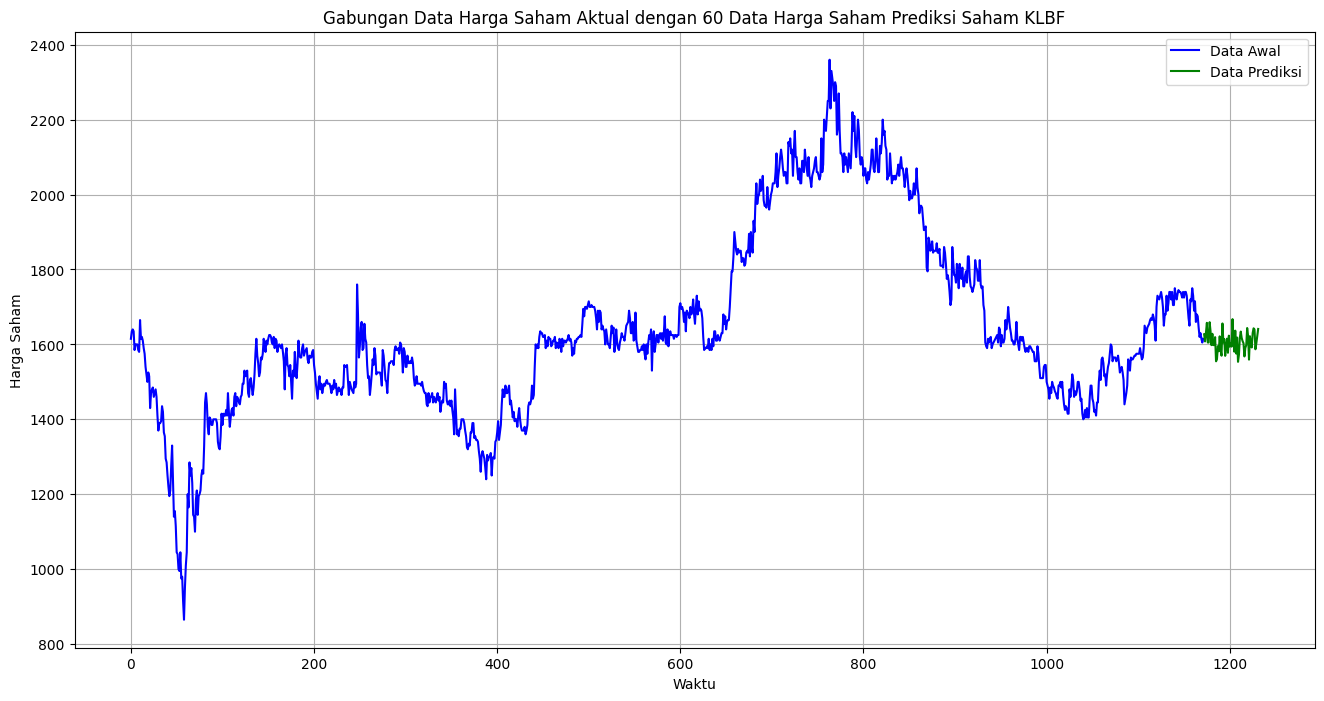

In [30]:
# ==============================================================================
# SEL 16: Visualisasi Gabungan Data Aktual & Prediksi Masa Depan
# ==============================================================================

future_df['Day'] = range(len(df), len(df) + 60)
# Gabungan data sebelumnya dengan prediksi masa depan
combined_df = pd.concat([
    pd.DataFrame({'Day': range(len(df)), 'Close': df['Close']}),
    future_df.rename(columns={'Future Predictions': 'Close'})
], ignore_index=True)

plt.figure(figsize=(16, 8))
plt.plot(combined_df['Day'][:len(df)], combined_df['Close'][:len(df)], label='Data Awal', color='blue')
plt.plot(combined_df['Day'][len(df):], combined_df['Close'][len(df):], label='Data Prediksi', color='green') #, marker='o')
plt.title(f'Gabungan Data Harga Saham Aktual dengan 60 Data Harga Saham Prediksi Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# ==============================================================================
# Menyimpan Prediksi Masa Depan
# ==============================================================================

# Simpan prediksi masa depan ke DataFrame
future_df.to_excel('future_predictions.xlsx', index=False)
print("\nPrediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'")


Prediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'


In [32]:
# ==============================================================================
# Visualisasi Return Harian
# ==============================================================================

print("\n=== Visualisasi Return Harian ===")
# Hitung return harian (dalam persen)
df['Return Harian'] = df['Close'].pct_change()
# Hapus nilai NaN pertama (karena tidak ada return untuk hari pertama)
df.dropna(inplace=True)

# Plot return saham dengan label berbahasa Indonesia
fig = px.line(
    df,
    x=df.index,
    y='Return Harian',
    title=f'Grafik <i>Return</i> Harian Saham {stock_name}',
    labels={
        'Date': 'Tanggal',
        'Return Harian': 'Return Harian'
    }
)

# Tambahkan pengaturan layout
fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='<i>Return</i> Harian',
    plot_bgcolor='white',
    font_size=15,
    title_x=0.5,
    font_family='Times New Roman',
    xaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray'),
    yaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray')
)

fig.show()


=== Visualisasi Return Harian ===
